In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import fancyimpute
from fancyimpute import IterativeImputer as MICE
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from mlens.visualization import corrmat
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import  RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer as Imputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from keras import models, layers, optimizers


Using TensorFlow backend.
[MLENS] backend: threading


Data types:
-----------
credit_policy          int64
purpose               object
int_rate             float64
installment          float64
log_annual_inc       float64
dti                  float64
fico                   int64
days_with_cr_line    float64
revol_bal              int64
revol_util           float64
inq_last_6mths       float64
delinq_2yrs          float64
pub_rec              float64
not_fully_paid         int64
dtype: object

Сумма пропущенных значений для каждого признака:
-----------------------------------
credit_policy         0
purpose               0
int_rate              0
installment           0
log_annual_inc        4
dti                   0
fico                  0
days_with_cr_line    29
revol_bal             0
revol_util           62
inq_last_6mths       29
delinq_2yrs          29
pub_rec              29
not_fully_paid        0
dtype: int64
Выплатил не полностью = 1533
Выплатил полностью = 8045
Процент заемщиков не выплативших кредит полностью = 19.06%


Text(0.5, 1, '')

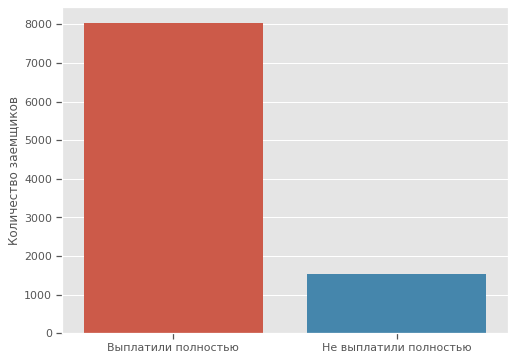

In [14]:
os.chdir("../")
# from scripts.plot_roc import plot_roc_and_pr_curves
os.chdir("c:/Users/sayra/diplom/code1/")

plt.style.use("ggplot")
sns.set_context("notebook")

df = pd.read_csv("c:/Users/sayra/diplom/code1/loans.csv")

# Проверка на тип данных и пропущенные значения
print(f"\033[1m\033[0mData types:\n{11 * '-'}")
print(f"\033[0m{df.dtypes}\n")
print(f"\033[1m\033[0mСумма пропущенных значений для каждого признака:\n{35 * '-'}")
print(f"\033[0m{df.isnull().sum()}")
df.head()
#print(df.head())

# Вычисление процента замещиков не выплативших кредит полностью 
pos = df[df["not_fully_paid"] == 1].shape[0]
neg = df[df["not_fully_paid"] == 0].shape[0]
print(f"Выплатил не полностью = {pos}")
print(f"Выплатил полностью = {neg}")
print(f"Процент заемщиков не выплативших кредит полностью = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df["not_fully_paid"])
plt.xticks((0, 1), ["Выплатили полностью", "Не выплатили полностью"])
plt.xlabel("")
plt.ylabel("Количество заемщиков")
plt.title("", y=1, fontdict={"fontsize": 20})
#plt.show()

In [15]:
df = pd.get_dummies(df, columns=["purpose"], drop_first=True)
df.head()
#print(df.head())

# Проверим все бинарные колонки на предмет пропущенных значений
for feature in df.columns:
    if np.any(np.isnan(df[feature])):
        df["is_" + feature + "_missing"] = np.isnan(df[feature]) * 1

df.head()
#print(df.head())

# Оригинальные данные
X = df.loc[:, df.columns != "not_fully_paid"].values
y = df.loc[:, df.columns == "not_fully_paid"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Оригинальная выборка: {X_train.shape, X_test.shape}")

# Drop NA and remove binary columns
train_indices_na = np.max(np.isnan(X_train), axis=1)
test_indices_na = np.max(np.isnan(X_test), axis=1)
X_train_dropna, y_train_dropna = X_train[~train_indices_na, :][:, :-6], y_train[~train_indices_na]
X_test_dropna, y_test_dropna = X_test[~test_indices_na, :][:, :-6], y_test[~test_indices_na]
print(f"После того как убрали пропущенные значения: {X_train_dropna.shape, X_test_dropna.shape}")


Оригинальная выборка: ((7662, 24), (1916, 24))
После того как убрали пропущенные значения: ((7611, 18), (1905, 18))


Baseline model's average AUC: 0.652
Mean imputation model's average AUC: 0.652
Median imputation model's average AUC: 0.651


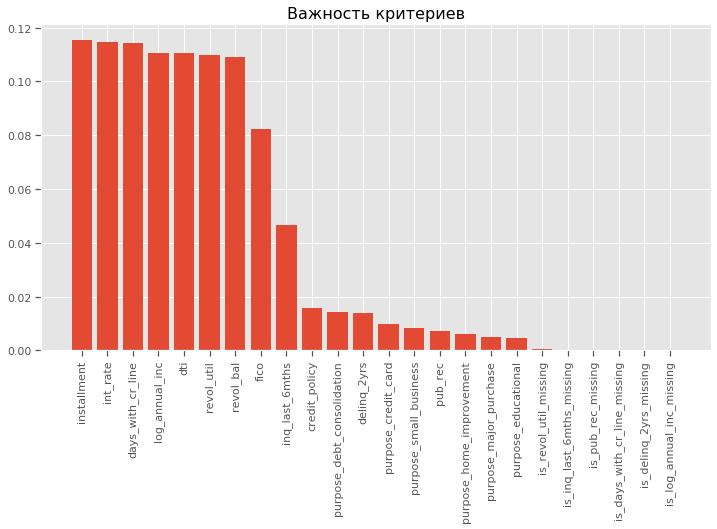

In [5]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")
# Build base line model -- Drop NA's
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train_dropna, y_train_dropna,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mBaseline model's average AUC: {scores.mean():.3f}")

# Build model with mean imputation 
pip_impute_mean = make_pipeline(Imputer(strategy="mean"),
                                RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mean,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMean imputation model's average AUC: {scores.mean():.3f}")

# Build model with median imputation
pip_impute_median = make_pipeline(Imputer(strategy="median"),
                                  RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_median,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMedian imputation model's average AUC: {scores.mean():.3f}")

# fit RF to plot feature importances
rf_clf.fit(RobustScaler().fit_transform(Imputer(strategy="median").fit_transform(X_train)), y_train)

# Plot features importance
importances = rf_clf.feature_importances_
indices = np.argsort(rf_clf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 25), importances[indices], align="center")
plt.xticks(range(1, 25), df.columns[df.columns != "not_fully_paid"][indices], rotation=90)
plt.title("Важность критериев", {"fontsize": 16});


In [6]:
for feat, importance in zip(df.columns, rf_clf.feature_importances_):
    print ('Признак: {f}, Важность: {i}'.format(f=feat, i=importance))

Признак: credit_policy, Важность: 0.015895492128776365
Признак: int_rate, Важность: 0.11449807978086414
Признак: installment, Важность: 0.11545402845077152
Признак: log_annual_inc, Важность: 0.11072650552153314
Признак: dti, Важность: 0.11059079271535854
Признак: fico, Важность: 0.0824700983492893
Признак: days_with_cr_line, Важность: 0.11439613168352249
Признак: revol_bal, Важность: 0.10897545961822826
Признак: revol_util, Важность: 0.10968212538240049
Признак: inq_last_6mths, Важность: 0.046766408137239875
Признак: delinq_2yrs, Важность: 0.013737898057596372
Признак: pub_rec, Важность: 0.007403381430068541
Признак: not_fully_paid, Важность: 0.00978797030594442
Признак: purpose_credit_card, Важность: 0.014347976207713931
Признак: purpose_debt_consolidation, Важность: 0.0046771116507618865
Признак: purpose_educational, Важность: 0.00619971468888122
Признак: purpose_home_improvement, Важность: 0.004987375075589298
Признак: purpose_major_purchase, Важность: 0.008335826326809525
Признак: 

In [11]:
# Drop generated binary features
X_train = X_train[:, :-6]
X_test = X_test[:, :-6]

In [16]:
df.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,...,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,is_log_annual_inc_missing,is_days_with_cr_line_missing,is_revol_util_missing,is_inq_last_6mths_missing,is_delinq_2yrs_missing,is_pub_rec_missing
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Build random forest classifier (same config)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Build model with no sampling
pip_orig = make_pipeline(Imputer(strategy="mean"),
                         RobustScaler(),
                         rf_clf)
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOriginal model's average AUC: {scores.mean():.3f}")

# Build model with undersampling
pip_undersample = imb_make_pipeline(Imputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mUnder-sampled model's average AUC: {scores.mean():.3f}")

# Build model with oversampling
pip_oversample = imb_make_pipeline(Imputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOver-sampled model's average AUC: {scores.mean():.3f}")

# Build model with EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(), resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mEasyEnsemble model's average AUC: {scores.mean():.3f}")

# Build model with SMOTE
pip_smote = imb_make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(),
                              SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mSMOTE model's average AUC: {scores.mean():.3f}")

Original model's average AUC: 0.651
Under-sampled model's average AUC: 0.652
Over-sampled model's average AUC: 0.647
EasyEnsemble model's average AUC: 0.661
SMOTE model's average AUC: 0.641


In [18]:
# Impute the missing data using features means
imp = Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

# Implement RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_sample(X_train, y_train)
# Shuffle the data
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

((2452, 24), (2452,))

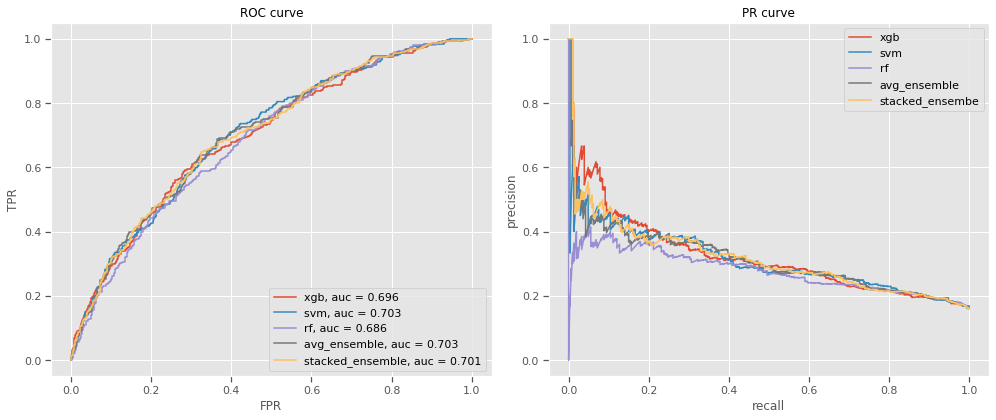

In [19]:
# Define base learners
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)

svm_clf = SVC(gamma=0.1,
                C=0.01,
                kernel="poly",
                degree=3,
                coef0=10.0,
                probability=True)

rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

# Define meta-learner
logreg_clf = LogisticRegression(penalty="l2",
                                C=100,
                                fit_intercept=True)

# Fitting voting clf --> average ensemble
voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(X_res, y_res)
xgb_model, svm_model, rf_model = voting_clf.estimators_
models = {"xgb": xgb_model, "svm": svm_model,
          "rf": rf_model, "avg_ensemble": voting_clf}

# Build first stack of base learners
first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))
# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack,
                                  X_res, y_res,
                                  cv=10,
                                  method="transform")
# Refit the first stack on the full training set
first_stack.fit(X_res, y_res)
# Fit the meta learner
second_stack = logreg_clf.fit(meta_features, y_res)

# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
            model_probs = model.predict_proba(X_test)[:, 1:]
            model_auc_score = roc_auc_score(y_test, model_probs)
            fpr, tpr, _ = roc_curve(y_test, model_probs)
            precision, recall, _ = precision_recall_curve(y_test, model_probs)
            axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
            axes[1].plot(recall, precision, label=f"{name}")
stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

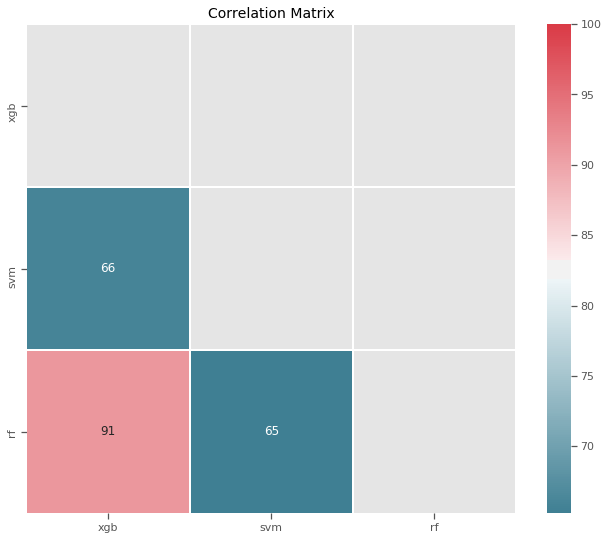

In [20]:
probs_df = pd.DataFrame(meta_features, columns=["xgb", "svm", "rf"])
corrmat(probs_df.corr(), inflate=True);


<Figure size 1152x576 with 0 Axes>

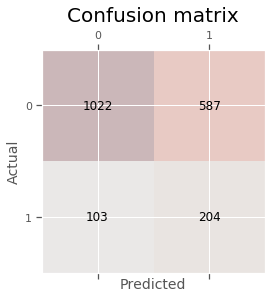

In [21]:
second_stack_probs = second_stack.predict_proba(first_stack.transform(X_test))
second_stack_preds = second_stack.predict(first_stack.transform(X_test))
conf_mat = confusion_matrix(y_test, second_stack_preds)
# Define figure size and figure ratios
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

C:\Users\sayra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sayra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sayra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
C:\Users\sayra\A

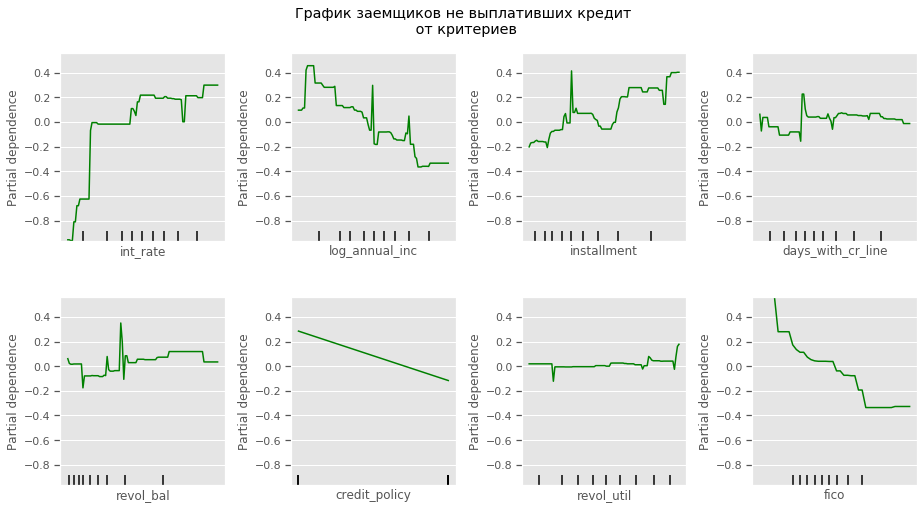

In [23]:
# Plot partial dependence plots
gbrt = GradientBoostingClassifier(loss="deviance",
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  max_depth=3,
                                  random_state=123)
gbrt.fit(X_res, y_res)
fig, axes = plot_partial_dependence(gbrt, X_res,
                                    np.argsort(gbrt.feature_importances_)[::-1][:8],
                                    n_cols=4,
                                    feature_names=df.columns[:-6],
                                    figsize=(14, 8))
plt.subplots_adjust(top=0.9)
plt.suptitle("График заемщиков не выплативших кредит\n"
             " от критериев")
for ax in axes: ax.set_xticks(())
for ax in [axes[0], axes[4]]: ax.set_ylabel("Partial dependence")